## Unit 1, Lesson 3.6 Data Cleaning ##

1. Determine the five most common journals and the total articles for each.
2. Next, calculate the mean, median, and standard deviation of the open-access cost per article for each journal.
3. BONUS: Identify the open access prices paid by subject area.

In [61]:
#preamble
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
%matplotlib inline
import re
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#Read in the data, using iso-8859-1 encoding
wellcome = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/wellcome.csv', encoding='iso-8859-1')
wellcome_clean = wellcome
wellcome_clean.columns = ['PMID/PMCID', 'Publisher', 'Journal title', 'Article title','Cost']

In [72]:
#First, let's clean the journal titles.

#Count how often the title occurs.
#Caveat: Some of the 'dirty' titles occur more than once. 
#NOTE: Sort_values does not seem to be assigning the sorted values back to the column. 

wellcome_clean['freq'] = wellcome_clean.groupby('Journal title')['Journal title'].transform('count')
wellcome_clean['freq'] = wellcome_clean['freq'].sort_values()

#Use title case for the journal title field.
#Strip trailing whitespace.
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).title())
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).strip())

#Clean inconsistent journal names by removing 'the' and spelling out abbreviations.
#NOTE: More cleaning needed.
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace(r'^J ', 'Journal of '))
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace('The Journal', 'Journal'))
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace('Org ', 'Organic '))
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace('Med ', 'Medicinal '))
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace(r'Chem$', 'Chemistry'))
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace('Psychiatty', 'Psychiatry'))

#NOTE: How can I get a regex to work inside str.replace? So far, no luck.
wellcome_clean['Journal title'] = wellcome_clean['Journal title'].apply(lambda x: str(x).replace('Birth Defects Research', r'Birth Defects Research$'))

print(wellcome_clean['Journal title'].unique())

['Psychological Medicine' 'Biomacromolecules' 'Journal Of Medicinal Chem'
 'Journal Of Organic Chem' 'Journal Of Medicinal Chemistry'
 'Journal Of Proteome Research' 'Mol Pharm' 'Acs Chemical Biology'
 'Journal Of Chemical Information And Modeling' 'Biochemistry'
 'Gastroenterology' 'Journal Of Biological Chemistry'
 'Journal Of Immunology' 'Acs Chemical Neuroscience' 'Acs Nano'
 'American Chemical Society' 'Analytical Chemistry'
 'Bioconjugate Chemistry' 'Journal Of The American Chemical Society'
 'Chest' 'Journal Of Neurophysiology' 'Journal Of Physiology'
 'American Journal Of Psychiatry' 'Americal Journal Of Psychiatry'
 'Behavioral Neuroscience' 'Emotion' 'Health Psychology'
 'Journal Of Abnormal Psychology'
 'Journal Of Consulting And Clinical Psychology'
 'Journal Of Experimental Psychology:  Animal Behaviour Process'
 'Journal Of Experimental Psychology: Human Perception And Performance'
 'Journal Of Family Psychology' 'Psychological Assessment'
 'Psychological Review'
 'Psycho

In [63]:
#Now let's clean the Price column.
#Use a regex to assign the numerical information, including decimal point, to its own column.
wellcome_clean['Price'] = wellcome_clean['Cost'].str.findall(r'\d+[.]\d+')
wellcome_clean['Price'] = wellcome_clean['Price'].apply(lambda x: x[0] if x else 0)
wellcome_clean['Price'] = wellcome_clean['Price'].apply(lambda x: pd.to_numeric(x))
wellcome_clean['Price'][:5]

0       0.00
1    2381.04
2     642.56
3     669.64
4     685.88
Name: Price, dtype: float64

In [64]:
#Use a regex to assign currency symbols to their own column.
#Caveat: For now, Price does not have any currency conversion, 
#so the values should not really be compared.

wellcome_clean['Currency'] = wellcome_clean['Cost'].str.findall(r'$')
wellcome_clean['Currency'] = wellcome_clean['Cost'].str.findall(r'£')

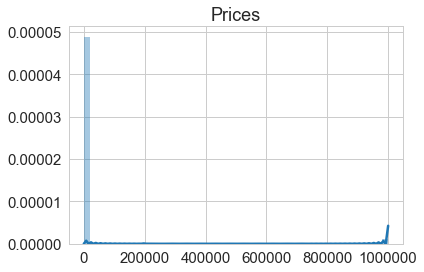

                      PMID/PMCID                           Publisher  \
46          23731076 PMC3670620   American Psychological Association   
47           23244291 PMC3569044  American Psychological Association   
49    PMID: 23477577 PMC3727344   American Psychological Association   
52                      23668184  American Psychological Association   
85                      23877697   American Society for Microbiology   
174                     23769672                     Biochem Journal   
280                          NaN                                 BMJ   
305                   PMC3624963                           BMJ Group   
415               PMID: 23994477           Darmouth Journal Services   
418                   PMC3644702          Dartmouth Journal Services   
419                   PMC3607254          Dartmouth Journal Services   
420                   PMC3675675          Dartmouth Journal Services   
421                   PMC3607223          Dartmouth Journal Serv

ValueError: cannot convert float NaN to integer

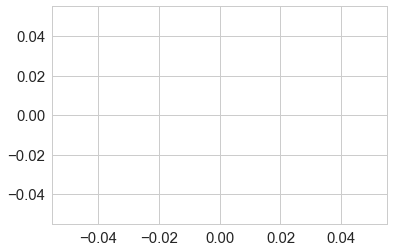

In [65]:
#Check Price for anomalous values.
ax = sns.distplot(wellcome_clean['Price'])
ax.set(xlabel='', ylabel='', title='Prices')
plt.show()

#Several articles are priced at 999999.00, probably a missingness indicator.
#Replace this value with the mean article price for that journal. 

#NOTE: means are showing up as NaN; 
#also tried including the calculation as the argument of .fillna(), to no avail.
#Not sure what is wrong here.
wellcome_clean[wellcome_clean['Price'] == 999999.00] = None
means = wellcome.groupby(['Journal title'])['Price'].mean()
wellcome_clean['Price'] = wellcome_clean['Price'].fillna(means)
#wellcome_clean['Price'] = wellcome_clean['Price'].fillna(wellcome_clean['Price'].groupby(wellcome_clean['Journal title']).mean())

#Recheck distribution.
outliers = wellcome_clean[wellcome_clean['Price'] > wellcome_clean['Price'].quantile(.95)]
print(outliers)

#There appear to be some high outliers with implausible values.
#Let's start with the highest one to find out what's going on.

#The max value is $201024.00.
#Other articles in the same journal are $2010.24, so this appears to be a decimal placement error. 
#Move the decimal over to correct the value, recheck the set of outliers for similar anomalies.
#Correct as necessary.

wellcome_clean['Price'].replace(201024.00, 2010.24, inplace=True)
wellcome_clean['Price'].replace(192645.00, 1926.45, inplace=True)
wellcome_clean['Price'].replace(13200.00, 1320.00, inplace=True)
wellcome_clean['Price'].replace(6000.00, 600.00, inplace=True)

#Plot again to get a sense for the real distribution, once NaN problem is fixed.
ax = sns.distplot(wellcome_clean['Price'])
ax.set(xlabel='', ylabel='', title='Prices')
plt.show()

#Remaining high values appear to be legitimate, so we will not change them.

In [66]:
print(wellcome_clean['Journal title'].value_counts()[:5])
print(wellcome_clean['Price'].groupby(wellcome_clean['Journal title']).describe())

Plos One                                           183
Journal Of Biological Chemistry                     59
Neuroimage                                          29
Nucleic Acids Research                              26
Proceedings Of The National Academy Of Sciences     22
Name: Journal title, dtype: int64
                                                    count         mean  \
Journal title                                                            
Academy Of Nutrition And Dietetics                    1.0  2379.540000   
Acs Chemical Biology                                  5.0  1418.186000   
Acs Chemical Neuroscience                             1.0  1186.800000   
Acs Nano                                              2.0   668.140000   
Acta Crystallographica Section D,  Biological C...    1.0   771.420000   
Acta Crystallographica Section D: Biological Cr...    1.0   773.740000   
Acta Crystallographica Section F: Structural Bi...    2.0   796.635000   
Acta Crystallographica, S

### Bonus: Subject areas

Let's try a few approaches to extract topics from the journal names. 

Coming soon!

My first attempt will use a bag-of-words model to identify important words. With the set of important words identified, I will create a dictionary mapping each to a journal topic. Then, I will write a function that loops through each item in the dictionary, assigning the key to a topic column whenever the value is in each journal title. After that, any remaining journal titles without topics can be manually assigned a topic.